In [1]:
import pickle
import numpy as np
import pandas as pd
import time
from empyrical import sortino_ratio
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import torch.nn as nn
import random
import tqdm
import statistics 
from tqdm import tqdm
from bayes_opt import BayesianOptimization
from scipy import stats
# Standardize time series data
from sklearn.preprocessing import StandardScaler
from math import sqrt
import pandas_datareader.data as web
from datetime import datetime
import pymongo

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
from pymongo import MongoClient
client = MongoClient()

In [3]:
db = client.trading_data

In [4]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        try:
            res.append(((block[i + 1] - block[i]) / block[i]) * 100 )
        except:
            res.append(0)
    return np.array([res])

In [5]:
# df = df.iloc[::-1]

In [6]:
class RNN(nn.Module):
    def __init__(self, i_size, h_size, n_layers, o_size):
        super(RNN, self).__init__()

        self.rnn = nn.LSTM(
            input_size=i_size,
            hidden_size=h_size,
            num_layers=n_layers
        )
        self.out = nn.Linear(h_size, o_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.rnn(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state

In [7]:
class Deep_Evolution_Strategy:

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

      
    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
#         writer = SummaryWriter(comment="Min-BTC_2018-5000")
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
                
            reward_mean = np.mean(rewards)
            reward_max = np.max(rewards)
            reward_std = np.std(rewards)
#             writer.add_scalar("reward_mean", reward_mean, i)
#             writer.add_scalar("reward_std", reward_std, i)
#             writer.add_scalar("reward_max", reward_max, i)
            print("reward_mean=%.2f, reward_max=%.2f, reward_std=%.2f" % (
            reward_mean, reward_max, reward_std))
            
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (
                    w
                    + self.learning_rate
                    / (self.population_size * self.sigma)
                    * np.dot(A.T, rewards).T
                )
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, self.reward_function(self.weights))
                )
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    
    DROPOUT = 0.9
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.normal(scale = 0.05, size = (input_size, layer_size)),
            np.random.normal(scale = 0.05, size = (layer_size, layer_size)),
            np.random.normal(scale = 0.05, size = (layer_size, layer_size)),
            np.random.normal(scale = 0.05, size = (layer_size, output_size)),
            np.zeros((1, layer_size)),
            np.zeros((1, layer_size)),
            np.zeros((1, layer_size)),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-3]
        feed = np.dot(feed, self.weights[1]) + self.weights[-2]
        feed = np.dot(feed, self.weights[2]) + self.weights[-1]
        decision = np.dot(feed, self.weights[3])
        return decision

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights        
        
class OldModel:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(layer_size, 1),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights
        

In [8]:
class Agent:
    def __init__(
        self,
        name,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        skip,
        window_size,
    ):
        self.name = name
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.net_worths = []
        self.commision = 0.0000
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])
      
      
    def get_reward(self, weights):
        initial_money = self.initial_money
        #print(initial_money)
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(close, 0, self.window_size + 1)
        inventory = []
        quantity = 0
        reward = 0
        last = close[0]
        
        
        for t in range(0, l, self.skip):
            action = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            if action == 1:
                if initial_money > 0:
                  #initial_money -= initial_money * self.commision 
                  buy_units = float(initial_money) / float(close[t])  
                  total_buy = buy_units * close[t]
                  initial_money -= total_buy
                  inventory.append(total_buy)
                  quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                if quantity > 0:
                  bought_price = inventory.pop(0)
                  #initial_money -= initial_money * self.commision 
                  sell_units = quantity
                  quantity -= sell_units 
                  total_sell = sell_units * close[t]
                  initial_money += total_sell
                  try:
                      invest = ((total_sell - bought_price) / bought_price) * 100
                  except:
                      invest = 0
            state = next_state
            
        profit = ((initial_money - starting_money) / starting_money) * 100
        return profit

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)    
    
    def _current_price(self):
        return 0
    
    def _take_action(self, action):
        return 0
    
    def loadModel(self,filename):
        infile = open(filename,'rb')
        self.model = pickle.load(infile)
        self.es.weights = self.model.get_weights()
        infile.close()
    
    def load(self):
        infile = open(self.name,'rb')
        self.model = pickle.load(infile)
        self.es.weights = self.model.get_weights()
        infile.close()

    def loadfile(self, name):
        infile = open(name,'rb')
        data = pickle.load(infile)
        infile.close()
        return data
        
    def saveFile(self, name, file):
        outfile = open(name,'wb')
        pickle.dump(file,outfile)
        outfile.close()

    def save(self):
        outfile = open(self.name,'wb')
        pickle.dump(self.model,outfile)
        outfile.close()
    
    def saveModel(self,filename):
        outfile = open(filename,'wb')
        pickle.dump(self.model,outfile)
        outfile.close()
    
    def saveData(self, state, action):
        X_train = self.loadfile("X_train")
        y_train = self.loadfile("y_train")

        X_train.append(state)
        y_train.append(action)

        self.saveFile("X_train", X_train)
        self.saveFile("y_train", y_train)

    def saveFiles(self, state, action):
        self.saveFile("X_train", state)
        self.saveFile("y_train", action)

    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        h_p = 0
        h_l = 0
        total_trades = 0
        X_train = []
        y_train = []
        # self.saveFile("X_train", [])
        # self.saveFile("y_train", [])

        for t in range(0, l, self.skip):
            action = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)

            #self.saveData(state,action)
            X_train.append(state)
            temp_a = [0,0,0]
            temp_a[action] = 1
            y_train.append([temp_a])

            if action == 1:
                if initial_money > 0:
                  #initial_money -= initial_money * self.commision 
                  buy_units = float(initial_money) / float(close[t])  
                  
                  total_buy = buy_units * close[t]
                  initial_money -= total_buy
                  inventory.append(total_buy)
                  quantity += buy_units
                  states_buy.append(t)
                  total_trades += 1
                  print(
                      '%d: buy %f units at price %f, total balance %f'
                      % (t, buy_units, close[t], initial_money)
                  )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                
                if sell_units <= 0:
                    continue
                    
                #initial_money -= initial_money * self.commision    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                total_trades += 1
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                    if invest < 0.05:
                        print(invest)
                        temp_y[0] = 1
                        y_train[-1] = temp_y
                        y_train.append([temp_y])

                    if invest > h_p and invest < 100:
                      h_p = invest
                    if invest < h_l:
                      h_l = invest
                    #print(invest)
                except:
                    invest = 0
                print(
                    '%d: sell %f units at price %f, investment %f %%, total balance %f'
                    % (t, sell_units, close[t], invest, initial_money)
                )
            else:
                print("hold")

            state = next_state
            self.net_worths.append(initial_money + close[-1] * quantity)
            
            
        if quantity > 0:
          initial_money += close[-1] * quantity
        
        self.saveFiles(X_train,y_train)
        
        profit = ((initial_money - starting_money) / starting_money) * 100
        
        print(
            '\ntotal gained %f, total investment %f %%, total time traded %d ticks,total trades %d, highest profit %f, highest loss %f'
            % (self.net_worths[-1], profit,l,total_trades,h_p,h_l)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()
    
        

In [9]:
class PyAgent:
    def __init__(
        self,
        model,
        money,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.model = model
        self.initial_money = money
        self.net_worths = []
        self.commision = 0.0000
        
        self.hidden_state = None

    def act(self, sequence):
        test_inputs = Variable(torch.from_numpy(sequence).float().unsqueeze(1))
        predicted_stock_price, self.hidden_state = self.model(test_inputs, self.hidden_state)
        return np.argmax(predicted_stock_price.cpu().detach().numpy()[0])

    def load(self,PATH):
        self.isPytorch = True
        self.model.load_state_dict(torch.load(PATH,map_location='cpu'))

    
    def saveData(self, state, action):
        X_train = self.loadfile("X_train")
        y_train = self.loadfile("y_train")

        X_train.append(state)
        y_train.append(action)

        self.saveFile("X_train", X_train)
        self.saveFile("y_train", y_train)


    def buy(self):
        initial_money = self.initial_money
        state = get_state(close, 0, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        h_p = 0
        h_l = 0
        total_trades = 0

        for t in range(0, l, self.skip):
            action = self.act(state)
            next_state = get_state(close, t + 1, self.window_size + 1)

            if action == 1:
                if initial_money > 0:
                  #initial_money -= initial_money * self.commision 
                  buy_units = float(initial_money) / float(close[t])  
                  
                  total_buy = buy_units * close[t]
                  initial_money -= total_buy
                  inventory.append(total_buy)
                  quantity += buy_units
                  states_buy.append(t)
                  total_trades += 1
                  print(
                      '%d: buy %f units at price %f, total balance %f'
                      % (t, buy_units, close[t], initial_money)
                  )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                
                if sell_units <= 0:
                    continue
                    
                #initial_money -= initial_money * self.commision    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                total_trades += 1
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                    if invest > h_p and invest < 100:
                      h_p = invest
                    if invest < h_l:
                      h_l = invest
                    #print(invest)
                except:
                    invest = 0
                print(
                    '%d: sell %f units at price %f, investment %f %%, total balance %f'
                    % (t, sell_units, close[t], invest, initial_money)
                )
            else:
                print("hold")
            
            state = next_state
            self.net_worths.append(initial_money + close[-1] * quantity)
            
            
        if quantity > 0:
          initial_money += close[-1] * quantity
        
        
        
        profit = ((initial_money - starting_money) / starting_money) * 100
        
        
        print(
            '\ntotal gained %f, total investment %f %%, total time traded %d ticks,total trades %d, highest profit %f, highest loss %f'
            % (self.net_worths[-1], profit,l,total_trades,h_p,h_l)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.show()
    
        

In [21]:
company = 'F'
start = datetime(1900, 1, 1)
end = datetime.now()
df = web.DataReader(company,'yahoo',start=start,end=end)
#df.head()

In [22]:
close = df.Close.values.tolist()
window_size = 300
skip = 1
l = len(close) - 1

In [238]:
modelname = '../models/50-F/10-TSLA/Model-3-300.model'
model = Model(window_size, 64, 3)
agent = Agent(modelname,100, 0.1, 0.01, model, 1000, skip, window_size)
agent.load()

In [23]:

INPUT_SIZE = 300
HIDDEN_SIZE = 64
NUM_LAYERS = 2
OUTPUT_SIZE = 3

# Hyper parameters

learning_rate = 0.001
num_epochs = 50

In [26]:
model = RNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
# infile = open('hidden_state','rb')
# data = pickle.load(infile)
# infile.close()
hidden_state = None

PATH = os.path.join(os.getcwd(), "model_"+str(8)+'.model')

agent = PyAgent(model, 1000, skip, window_size)
agent.load(PATH)

nits at price 12.670000, investment 0.715423 %, total balance 191754192.356000
hold
hold
hold
hold
11286: buy 15110653.955609 units at price 12.690000, total balance 0.000000
11287: sell 15110653.955609 units at price 12.660000, investment -0.236405 %, total balance 191300876.772312
hold
11289: buy 15279622.186730 units at price 12.520000, total balance 0.000000
hold
hold
hold
hold
hold
11295: sell 15279622.186730 units at price 12.550000, investment 0.239614 %, total balance 191759261.357814
11296: buy 15158835.347071 units at price 12.650000, total balance 0.000000
11297: sell 15158835.347071 units at price 12.700000, investment 0.395258 %, total balance 192517206.016486
hold
hold
hold
hold
hold
11303: buy 16567745.947721 units at price 11.620000, total balance 0.000000
11304: sell 16567745.947721 units at price 11.460000, investment -1.376935 %, total balance 189866369.192888
hold
hold
11307: buy 16255681.869182 units at price 11.680000, total balance 0.000000
11308: sell 16255681.8

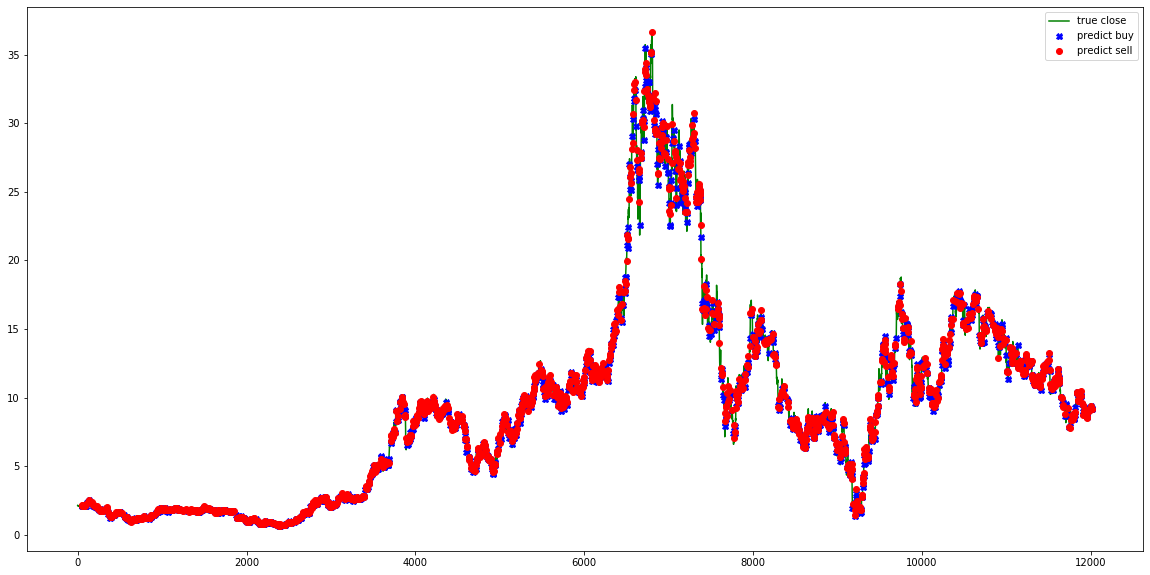

In [27]:
agent.buy()

In [239]:
((close[-1] - close[0]) / close[0]) * 100 #27687878.820070

-97.56249994039536

In [240]:
agent.fit(25,1)

reward_mean=-83.70, reward_max=59.57, reward_std=32.65
iter 1. reward: -46.037186
reward_mean=-73.24, reward_max=54.10, reward_std=34.42
iter 2. reward: -39.046447
reward_mean=-46.95, reward_max=633.72, reward_std=88.81
iter 3. reward: -27.692976
reward_mean=-24.88, reward_max=531.05, reward_std=107.13
iter 4. reward: 25.074343
reward_mean=-16.57, reward_max=370.53, reward_std=86.33
iter 5. reward: 12.226258
reward_mean=21.03, reward_max=459.15, reward_std=106.66
iter 6. reward: 86.165532


In [0]:
agent.saveModel("../models/50-F/10-TSLA/Model-3-300-PLUG.model")

In [4]:
import alpaca_trade_api as tradeapi
import requests
import time
from ta import macd
import numpy as np
from datetime import datetime, timedelta
from pytz import timezone
from pymongo import MongoClient

In [23]:
# Replace these with your API connection info from the dashboard
base_url = 'https://paper-api.alpaca.markets'#'https://api.alpaca.markets'
api_key_id = 'PKMB2NK7A6QDUSX8LYDE'
api_secret = 'o4FaZRbBJ4O3hZ8cLZDIJhbYjFBVqzKlRFuHSyVb'

api = tradeapi.REST(
    base_url=base_url,
    key_id=api_key_id,
    secret_key=api_secret
)

session = requests.session()

# We only consider stocks with per-share prices inside this range
min_share_price = 2.0
max_share_price = 13.0
# Minimum previous-day dollar volume for a stock we might consider
min_last_dv = 50000
# Stop limit to default to
default_stop = .95
# How much of our portfolio to allocate to any one position
risk = 0.01


In [24]:
def get_tickers():
    print('Getting current ticker data...')
    tickers = api.polygon.all_tickers()
    print('Success.', tickers)
    assets = api.list_assets()
    symbols = [asset.symbol for asset in assets if asset.tradable]
    return [ticker for ticker in tickers if (
        ticker.ticker in symbols and
        ticker.lastTrade['p'] >= min_share_price and
        ticker.lastTrade['p'] <= max_share_price 
        #ticker.prevDay['v'] * ticker.lastTrade['p'] > min_last_dv 
        #ticker.todaysChangePerc >= 3.5
    )]

In [25]:
get_tickers()

Getting current ticker data...
Success. []


[]